In [45]:
import numpy as np
import pyart
import matplotlib.pyplot as plt
import os
#import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture
import pickle
from netCDF4 import num2date, date2num
import math

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import geopandas as gpd
import metpy
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import cartopy.io.img_tiles as cimgt
import glob
import pandas as pd
from cartopy.io.img_tiles import MapboxTiles
#from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import scipy.ndimage as spyi
from string import ascii_lowercase as alphabet
import xarray
from metpy.plots.ctables import registry
from matplotlib.colorbar import make_axes as make_cbax

In [2]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [3]:
fls = glob.glob('./datasets/h8_data/*.nc')

In [4]:
h8_df = pd.DataFrame({'paths':fls})

In [5]:
def get_datetime_from_filename_h8(filename):
    fn = os.path.basename(filename).split('.')[0]
    strdatetime = fn.split('_')[0].split('-')[0]
    return pd.to_datetime(strdatetime, format='%Y%m%d%H%M%S',utc=True)

def get_band_h8(filename):
    fn = os.path.basename(filename).split('.')[0]
    return fn.split('_')[2].split('-')[0]

h8_df['datetime'] = h8_df['paths'].apply(get_datetime_from_filename_h8)
h8_df['band'] = h8_df['paths'].apply(get_band_h8)

In [6]:
plot_set_timestamps_15M = pickle.load( open( "./datasets/plot_set_timestamps_15M.pickle", "rb" ) )
#photo_df_15M = get_nearest_from_ts_index(photos_df.sort_index(),plot_set_timestamps_15M)

In [7]:
band = 'B13'
def get_nearest_from_ts_index_h8_band(h8_df,band,plot_set_timestamps):
    matching_rows = []
    df = h8_df[h8_df['band']==band].set_index('datetime')
    target_idx = []
    for ts in plot_set_timestamps:
        matching_rows.append(df.iloc[df.index.get_loc(ts, method='nearest')])

    return pd.DataFrame(matching_rows)

h8_df_15M = get_nearest_from_ts_index_h8_band(h8_df,band,plot_set_timestamps_15M)

//anaconda3/envs/pyart_env/lib/python3.7/site-packages/pandas/core/indexes/base.py:3071: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


In [8]:
def load_h8(path):
    C = xarray.open_dataset(path)
    dat = C.metpy.parse_cf('channel_00{}_brightness_temperature'.format(band.strip('B')))[0,:,:]
    geos = dat.metpy.cartopy_crs
    x = dat.x
    y = dat.y
    return dat, geos, x, y

In [9]:
 with open("./mbox_key.txt", "r") as f:
        mbox_key = f.read()

In [10]:
def formatmap(ax):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax


In [31]:
def apply_subplot_ticks(ax,x_custom=None,y_custom=None):
    gl = ax.gridlines(draw_labels=True, alpha=0.2)
    gl.xlabels_bottom = gl.ylabels_left = gl.xlabels_top = gl.ylabels_right = False
    if ax in axs[-1]:
        if x_custom is not None:
            lon_formatter = LongitudeFormatter(number_format='.3f',dateline_direction_label=True)
            ax.set_xticks(x_custom, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            gl.xlabels_bottom = True
            gl.xformatter = LONGITUDE_FORMATTER

    if ax in axs[:,0]:
        if y_custom is not None:
            lat_formatter = LatitudeFormatter(number_format='.3f',dateline_direction_label=True)
            ax.set_xticks(y_custom, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(lat_formatter)
        else:
            gl.ylabels_left = True
            gl.yformatter = LATITUDE_FORMATTER

### Define some functions for working with the isochrones, (from the Analysis-Isochrone nb)

In [12]:

def parse_isochrone_source(filename):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    return ''.join(fn_list[-1])

def parse_isochrone_time(filename,origin_tz=None):
    fn_list = os.path.basename(filename).split('.')[0].split('_')
    strdate, strtime = ''.join(fn_list[1:4]), fn_list[4]
    dt = pd.to_datetime(strdate+strtime, format='%d%m%Y%H%M')
    if origin_tz is not None:
        dt = dt.tz_localize(tz=origin_tz)
        dt = dt.tz_convert('utc')
    else:
        dt = dt.tz_localize(tz='utc')
    return dt

def parse_isochrones(fls):
    isochrone_df = pd.DataFrame({'paths':fls})

    isochrone_df['source'] = isochrone_df['paths'].apply(parse_isochrone_source)

    final_isochrone = isochrone_df[isochrone_df.source == 'final']
    isochrone_df = isochrone_df[isochrone_df.source != 'final'].copy()

    isochrone_df['datetime'] = isochrone_df['paths'].apply(parse_isochrone_time,origin_tz='Australia/Brisbane')
    isochrone_df = isochrone_df.set_index(['datetime'])
    
    start_time = isochrone_df.index.min()
    end_time = isochrone_df.index.max()
    print('Data collection duration: {}'.format(end_time-start_time))
    
    return final_isochrone, isochrone_df

def load_shapefiles_into_gdf(isochrone_df):

    isochrones_gdf = gpd.GeoDataFrame()

    for dt, row in isochrone_df.iterrows():
        iso = gpd.read_file(row['paths'])
        iso['datetime'] = dt
        iso['source'] = row['source']
        if bool(iso.crs):
            isochrones_gdf = isochrones_gdf.append(iso)
        else: 
            print('File is missing crs: {}'.format(row['paths']))
            print('Skipping...')
        
    isochrones_gdf = isochrones_gdf[['geometry','datetime','source']].reset_index()
        
    return isochrones_gdf
def add_isochrones(ax,final_only=False,**final_kwargs):
    handles = []
    labels = []
    
    ax.add_geometries(final_gdf['geometry'],crs=ccrs.PlateCarree(),**final_kwargs)

    if 'facecolor' in final_kwargs.keys():
        handles.append(mpatches.Rectangle((0, 0), 1, 1, **final_kwargs))
    else:
        handles.append(Line2D([0], [0], **final_kwargs))
        
    labels.append('Final perimeter')
        
        
        
    if not final_only:

        color=iter(plt.cm.rainbow_r(np.linspace(0,1,len(isochrones_gdf))))
        for i, row in isochrones_gdf.iloc[::-1].iterrows():
            c=next(color)
            ax.add_geometries([row['geometry']],facecolor=c,crs=ccrs.PlateCarree())
            handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=c))
            labels.append('{} ({})'.format(row['datetime'].tz_convert(target_tz).strftime(time_str_format_map),row['source']))

    return handles, labels

Load up the isochrone data

In [13]:
fls = glob.glob('./datasets/Perimeter Shapefiles/*.shp')
fls.sort()
final_isochrone, isochrone_df = parse_isochrones(fls)
final_gdf = gpd.read_file(final_isochrone.iloc[0].paths)
isochrones_gdf = load_shapefiles_into_gdf(isochrone_df)

Data collection duration: 1 days 12:58:00
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_5_12_2016_1348_MODIS.shp
Skipping...
File is missing crs: ./datasets/Perimeter Shapefiles/Perimeter_6_12_2016_1338_VIIRS.shp
Skipping...


Should already be in the right proj, but just incase 

In [14]:
crs_proj4 = ccrs.PlateCarree().proj4_init
isochrones_gdf = isochrones_gdf.to_crs(crs_proj4)

### Define functions from the Analysis-lightning nb

In [15]:
def dt_parser(ts):
    return pd.to_datetime(ts, format='%Y %m %d %H %M %S',utc=True)

def load_lightning_data(path,header):
    lightning = pd.read_csv(path,names=header,parse_dates=[[0,1,2,3,4,5]],date_parser=dt_parser)
    lightning.rename(columns={'_'.join(header[0:6]):'datetime'},inplace=True)
    lightning = lightning.set_index(['datetime'])
    return lightning

def select_between_dt(lightning,end,start=None,delta='15T'):
    if start is None:
        start = end - pd.Timedelta('15T')
    df = lightning.loc[start.strftime('%Y-%m-%d %H:%M:%S'):end.strftime('%Y-%m-%d %H:%M:%S')].copy()
    return df
def plot_lightning(lightning,**kwargs):
    ax.scatter(lightning.lon,lightning.lat,transform=ccrs.PlateCarree(),**kwargs)
    return

Load lighting data up

In [16]:
header = ['year', 'month', 'day', 'hour', 'minute', 'second', 'millisecond', 'lat', 'lon', 'current']
lightning = load_lightning_data('./datasets/lightning_data/Sedgerly_GPATS.txt',header=header)

## Plot a single scan in it's own fig

In [17]:
def clip_clean_IR(dat,upperBound=290.,convert_to_celcius=True):
    data = np.ma.masked_where(upperBound < dat,dat)
    if convert_to_celcius:
        data = data-273.15
    return data

In [18]:
dat, geos, x, y = load_h8(h8_df_15M.iloc[-1].paths)
cleanIR = clip_clean_IR(dat,upperBound=290.)

In [19]:
IR_tick_dict = pickle.load( open( "./datasets/IR_ticks.pickle", "rb" ) )

In [28]:
x0x1y0y1 = [lightning.lon.min()-0.15, lightning.lon.max()+0.15, lightning.lat.max(), lightning.lat.min()]

In [21]:
tiler = MapboxTiles(mbox_key,'outdoors')
mercator = tiler.crs

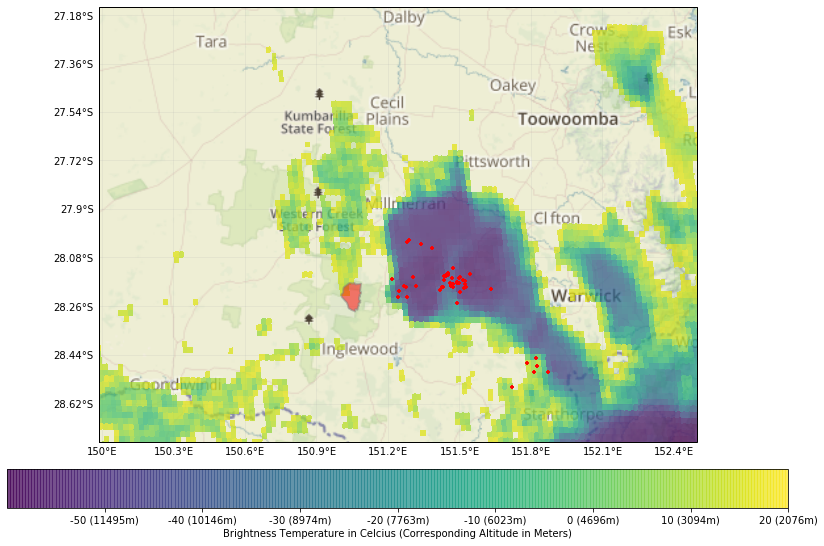

<IPython.core.display.Javascript object>

In [29]:
%%notify
#wv_norm, wv_cmap = registry.get_with_range('ir_tpc', 90, 313)

target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format_map = '%d/%m/%Y %H:%M'

fig = plt.figure(figsize=(20,10))

ax = plt.axes(projection=mercator)
ax.add_image(tiler, 8,interpolation='bilinear',zorder=1)

ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
lightning_kwargs = {'color':'red','marker':'+','s':10}

cleanIR = clip_clean_IR(dat,upperBound=290.)
IR_kwargs = {'vmin':-60,
             'vmax':20,
             'extent':(x.min(), x.max(), y.min(), y.max()),
             'origin':'upper',
             'transform':geos,
             'interpolation':'none',
             'alpha':0.75,
             'zorder':2}
im = ax.imshow(cleanIR,**IR_kwargs)

plot_lightning(select_between_dt(lightning,plot_set_timestamps_15M[-1]),**lightning_kwargs,zorder=3)
ax = formatmap(ax)
iso_kwargs={'zorder':5,'lw':2,'edgecolor':'grey','facecolor':'red','alpha':0.5}
handles, labels = add_isochrones(ax,final_only=True,**iso_kwargs)

cax,kw = make_cbax(ax,location='bottom',pad=0.05,shrink=0.7)
out=fig.colorbar(im,cax=cax,**kw,ticks=IR_tick_dict['IR_ticks'])
out.ax.set_xticklabels(IR_tick_dict['IR_labels']) 
out.set_label('Brightness Temperature in Celcius (Corresponding Altitude in Meters)',size=10)
#fig.legend(handles,labels, bbox_to_anchor=(0, 1),loc='lower right')

plt.show()

## Plot all in plot subset in subplots

Plotted: 15:50 (AEST)
Plotted: 16:00 (AEST)
Plotted: 16:20 (AEST)
Plotted: 16:30 (AEST)
Plotted: 16:50 (AEST)
Plotted: 17:00 (AEST)
Plotted: 17:20 (AEST)
Plotted: 17:30 (AEST)
Plotted: 17:50 (AEST)
Plotted: 18:00 (AEST)
Plotted: 18:20 (AEST)
Plotted: 18:30 (AEST)
Plotted: 18:50 (AEST)
Plotted: 19:00 (AEST)
Plotted: 19:20 (AEST)


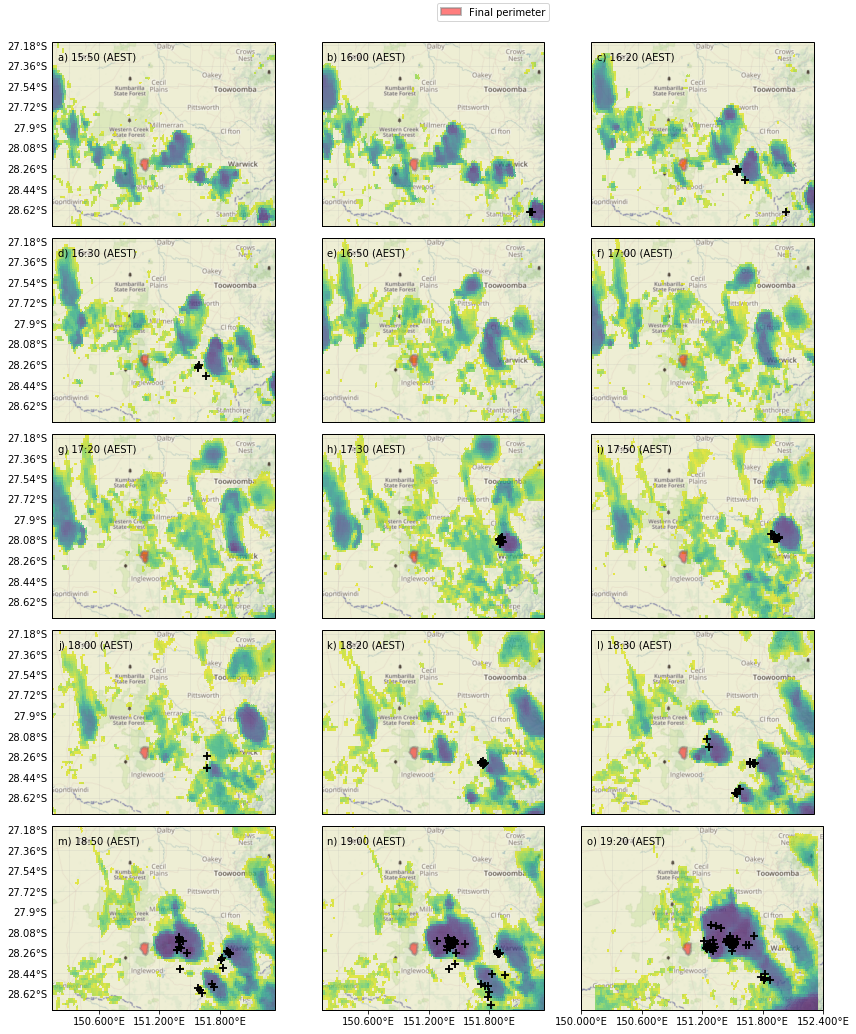

<IPython.core.display.Javascript object>

In [46]:
%%notify

tiles = True
save = True
nrow = 5; ncol = 3;
assert nrow*ncol == len(h8_df_15M)
target_tz = 'Australia/Brisbane'
target_tz_name = 'AEST'
time_str_format = '%H:%M'
time_str_format_map = '%d/%m/%Y %H:%M'
save_str = './fig_cleanIR_subplot_15M.png'
x0x1y0y1 = [lightning.lon.min(), lightning.lon.max(), lightning.lat.max(), lightning.lat.min()]

lightning_kwargs = {'color':'black','marker':'+','s':50}
iso_kwargs={'zorder':5,'lw':2,'edgecolor':'grey','facecolor':'red','alpha':0.5}
IR_kwargs = {'vmin':-60,
             'vmax':20,
             'extent':(x.min(), x.max(), y.min(), y.max()),
             'origin':'upper',
             'transform':geos,
             'interpolation':'none',
             'alpha':0.75,
             'zorder':2}

fig, axs = plt.subplots(nrows=nrow, ncols=ncol,figsize=(12,14),sharex=True,subplot_kw={'projection': mercator})

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_extent(x0x1y0y1, crs=ccrs.PlateCarree())
    if tiles:
        ax.add_image(tiler, 8,interpolation='bilinear')
        
    #Load and plot IR
    dat, geos, x, y = load_h8(h8_df_15M.iloc[i].paths)
    cleanIR = clip_clean_IR(dat,upperBound=290.)
    im = ax.imshow(cleanIR, **IR_kwargs)
    
    #Plot lightning
    plot_lightning(select_between_dt(lightning,h8_df_15M.iloc[i].name),**lightning_kwargs,zorder=3)
    
    #Add fire mapping
    handles, labels = add_isochrones(ax,final_only=True,**iso_kwargs)
    
    #Apply tickts
    apply_subplot_ticks(ax,x_custom=[150.,150.6,151.2,151.8,152.4])
    
    #Add label
    ds_string = '{} ({})'.format(h8_df_15M.iloc[i].name.tz_convert(target_tz).strftime(time_str_format),target_tz_name)
    ax.text(.025,.9,'{}) {}'.format(alphabet[i],ds_string),
        horizontalalignment='left',
        transform=ax.transAxes)
    print('Plotted: {}'.format(ds_string))


fig.canvas.draw()
plt.tight_layout()

# cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
# out=fig.colorbar(im,cax=cax,**kw)
# out.set_label('Brightness temperature (K)',size=10)

fig.legend(handles,labels,ncol=1, bbox_to_anchor=(0.5, 1),loc='lower left')

if save:
    plt.savefig(save_str,dpi=300)
plt.show()

In [24]:
300-273.15

26.850000000000023

In [40]:
import matplotlib as mpl

In [ ]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.magma#(np.linspace(0,1,max_agreement))
norm = mpl.colors.Normalize(vmin=1/26, vmax=max_agreement/26)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Ensemble Agreement (%)')
plt.savefig('crowning_colorbar.png',dpi=300)
fig.show()

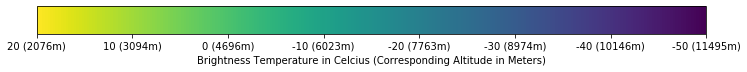

In [48]:
#color=iter(plt.cm.viris(np.linspace(0,1,len(IR_tick_dict['IR_ticks']))))

import matplotlib as mpl

fig, ax = plt.subplots(figsize=(12, 1))
fig.subplots_adjust(bottom=0.5)

norm = mpl.colors.Normalize(vmin=IR_tick_dict['IR_ticks'][-1], vmax=IR_tick_dict['IR_ticks'][0])

cmap = mpl.cm.viridis
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal',
                                ticks=IR_tick_dict['IR_ticks'])
#out=fig.colorbar(im,cax=cax,**kw,ticks=IR_tick_dict['IR_ticks'])
cb1.ax.set_xticklabels(IR_tick_dict['IR_labels']) 
cb1.set_label('Brightness Temperature in Celcius (Corresponding Altitude in Meters)',size=10)
cb1.ax.invert_xaxis()
plt.savefig('h8_colorbar.png',dpi=300)
#fig.show()

In [37]:
IR_tick_dict['IR_ticks'][0]

-50.0